In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import os
import re


In [26]:
# Convert Excel to Parquet
excel_path = "../data/raw/Hi_res/THB_final.xlsx"
# Load all sheet names
sheets = pd.ExcelFile(excel_path).sheet_names

# Loop over sheets and save each as a separate .parquet file
for sheet in sheets:
    df = pd.read_excel(excel_path, sheet_name=sheet)

    # Convert any columns that start with 'fit' to numeric, replacing non-numeric values with NaN
    fit_columns = [col for col in df.columns if col.startswith('fit')]
    for col in fit_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    parquet_path = f"{sheet.replace(' ', '_')}.parquet"
    df.to_parquet(parquet_path, index=False)
    print(f"✅ Saved: {parquet_path}")


✅ Saved: AsDeposited.parquet
✅ Saved: Water.parquet
✅ Saved: UV_Water.parquet


In [18]:
def plot_stacked_region(ax, region_df, title, colormap='viridis'):
    """
    Plot a single XPS region with raw data, envelope, and valid fit peaks.
    Skips any flat or malformed fits, uses updated colormap syntax.
    """
    x = region_df['B.E.']
    ax.plot(x, region_df['raw'], 'x', color='white', label='Raw')

    if 'Envelope' in region_df.columns:
        ax.plot(x, region_df['Envelope'], '-', color='black', label='Envelope')

    # Strict valid fit detection
    fit_cols = [
        col for col in region_df.columns
        if re.match(r'^fit\d*(\.\d+)?$', str(col))
        and region_df[col].notna().any()
        and region_df[col].nunique(dropna=True) > 1
        and (region_df[col].max() - region_df[col].min()) > 1e-3
    ]

    base_cmap = matplotlib.colormaps.get_cmap(colormap)
    colors = [base_cmap(i / len(fit_cols)) for i in range(len(fit_cols))]

    for j, col in enumerate(fit_cols):
        y = region_df[col]
        ax.fill_between(x, y, color=colors(j), alpha=0.5, label=f'Fit {j+1}')

    ax.set_title(title)
    ax.set_xlabel("Binding Energy (eV)")
    ax.invert_xaxis()
    ax.legend(fontsize=8)


In [19]:
def plot_parquet_xps(file_path, save_path=None, colormap='viridis'):
    """
    Plot O 1s, C 1s, and Al 2p from a stacked-block .parquet file with 'Region' column.
    """
    df = pd.read_parquet(file_path)

    region_order = ['O 1s', 'C 1s', 'Al 2p']
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    for ax, region in zip(axes, region_order):
        region_df = df[df['Region'] == region]
        if not region_df.empty:
            plot_stacked_region(ax, region_df, region, colormap)
            if ax == axes[0]:
                ax.set_ylabel("Intensity (a.u.)")

    plt.tight_layout()
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=600)
    plt.show()


TypeError: 'list' object is not callable

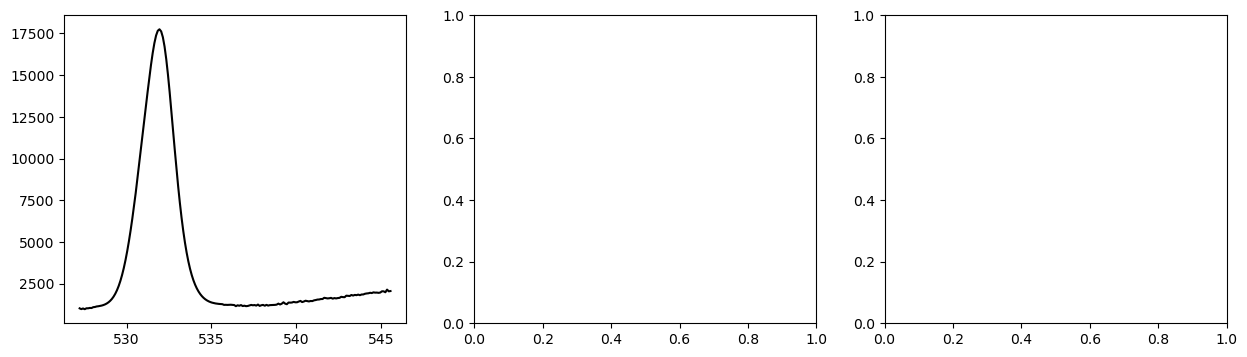

In [20]:
plot_parquet_xps(
    file_path="BTY.AsDeposited.parquet",
    save_path="figures/XPS_AsDeposited.png",
    colormap="viridis"  # or any valid Matplotlib colormap
)


In [ ]:
# Example usage - plot all parquet files
plot_all_parquet_files()


In [ ]:
# Print the absolute path of the figures directory
import os
print(f"Figures are being saved to: {os.path.abspath('../figures/final/')}")